In [1]:
%pylab inline
import pandas as pd
import tqdm

Populating the interactive namespace from numpy and matplotlib


# Load the train data

In [2]:
# Su questo file ci sono i commenti raggruppati per autore e vettorizzati tramite w2v. Sono 5000 vettori di 200 
# componenti l'uno 
train_w2v = pd.read_pickle("TrainW2VXAuthor.csv")  

In [3]:
print (train_w2v.shape[0])
train_w2v.W2V.head()

5000


0    [-0.12935811, -0.13093102, -0.11762878, 0.0317...
1    [-0.03992967, -0.15108569, -0.05405604, 0.0688...
2    [-0.010448196, -0.16257766, -0.062682435, 0.08...
3    [-0.048508164, -0.18944433, -0.035430044, 0.03...
4    [-0.046319243, -0.19266394, -0.04684512, 0.080...
Name: W2V, dtype: object

# Model Selection

In [4]:
from sklearn.preprocessing import StandardScaler # For scaling
from sklearn.model_selection import train_test_split # for creating valid set and train set 
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.svm import SVC, LinearSVC

In [5]:
#Dataset
X = np.array(list(map(np.array, train_w2v.W2V)))
y = np.array(list(map(np.array, train_w2v.gender)))


In [6]:
# Training set + validation set
SEED = 20003
x_train , x_validation, y_train , y_validation = train_test_split(X, y, test_size = 1000, 
                                                                 random_state = SEED)

# Il validation set è di dimensione 1000 (1/5 del totale --> rule of thumb) perchè dopo questa classificazione dobbiamo 
# fare una regressione logistica e quindi dobbiamo dividere i 1000 ulteriormente in 800 per il training e 200 per 
# validation della logistica 


In [7]:
# MLP : semplice e si allena in fretta -- alcuni accorgimenti sui parametri 

mlpClf = MLPClassifier(solver = 'adam', activation= 'relu' ,alpha = 0.05, verbose = True, early_stopping = True,
                         learning_rate = 'invscaling', max_iter = 400)

# Cross validation - 10 Fold 
kf = KFold(n_splits = 10)

for train_indices, test_indices in kf.split(x_train):
    mlpClf.fit(x_train[train_indices], y_train[train_indices])
    print(mlpClf.score(x_train[test_indices], y_train[test_indices]))


Iteration 1, loss = 0.64372279
Validation score: 0.725000
Iteration 2, loss = 0.60491113
Validation score: 0.725000
Iteration 3, loss = 0.59591275
Validation score: 0.725000
Iteration 4, loss = 0.58848014
Validation score: 0.725000
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
0.6975
Iteration 1, loss = 0.65071396
Validation score: 0.733333
Iteration 2, loss = 0.61077086
Validation score: 0.733333
Iteration 3, loss = 0.59683232
Validation score: 0.733333
Iteration 4, loss = 0.58586966
Validation score: 0.733333
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
0.72
Iteration 1, loss = 0.62437554
Validation score: 0.750000
Iteration 2, loss = 0.60492102
Validation score: 0.750000
Iteration 3, loss = 0.59171695
Validation score: 0.750000
Iteration 4, loss = 0.58069969
Validation score: 0.750000
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
0.72
Itera

In [8]:
y_score = mlpClf.predict_proba(x_validation)[:,1]

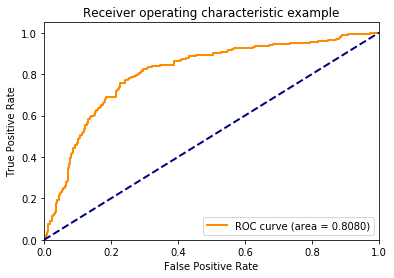

In [9]:
# Roc Curve for validation data 

# Utilizziamo la metrica roc perchè avremo la stessa nell'upload della sfida 

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_validation, y_score)
roc_auc = auc(fpr, tpr) 

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)'% roc_auc )

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [10]:
score = pd.DataFrame({"y_validation":y_validation, "W2VGender":y_score})

In [11]:
score.to_csv('scoreW2VAugValidation.csv')

# Test Set 

In [12]:
test_data_prob = pd.read_pickle('TestW2VXAuthorNoBody.csv')

In [23]:
print (test_data_prob.shape[0])
test_data_prob.head()

15000


,author,sentences
0,ejchristian86,"[-0.037951056, -0.14019315, -0.06349655, 0.064..."
1,ZenDragon,"[-0.017164167, -0.1381231, -0.08678613, 0.0696..."
2,savoytruffle,"[-0.041860316, -0.1620547, -0.05505575, 0.0649..."
3,hentercenter,"[-0.037720606, -0.13322686, -0.058957513, 0.06..."
4,rick-o-suave,"[-0.024876451, -0.17049082, -0.049554985, 0.08..."


In [14]:
listofzeros = [0]*200

In [15]:
# Problemi con emojis --> erano rimasti dei commenti vuoti che davano errore 

test_data_prob.sentences[11377] = listofzeros
test_data_prob.sentences[11460] = listofzeros
test_data_prob.sentences[12941] = listofzeros
test_data_prob.sentences[13161] = listofzeros
test_data_prob.sentences[14152] = listofzeros

In [16]:
X_test = np.array(list(map(np.array, test_data_prob.sentences)))

In [17]:
np.where(pd.isnull(test_data_prob.sentences))

(array([], dtype=int64),)

In [18]:
y_scoreTest = mlpClf.predict_proba(X_test)[:,1]

In [19]:
y_scoreTest[11377] = 0.5
y_scoreTest[11460] = 0.5
y_scoreTest[12941] = 0.5
y_scoreTest[13161] = 0.5
y_scoreTest[14152] = 0.5

In [20]:
solutionW2V = pd.DataFrame({"author":test_data_prob.author, "W2VGender":y_scoreTest})

In [21]:
solutionW2V.head()

,author,W2VGender
0,ejchristian86,0.378125
1,ZenDragon,0.107748
2,savoytruffle,0.239868
3,hentercenter,0.287511
4,rick-o-suave,0.119092


In [22]:
solutionW2V.to_csv('solutionW2V.csv')